Adding the Image below so location classification is easier:

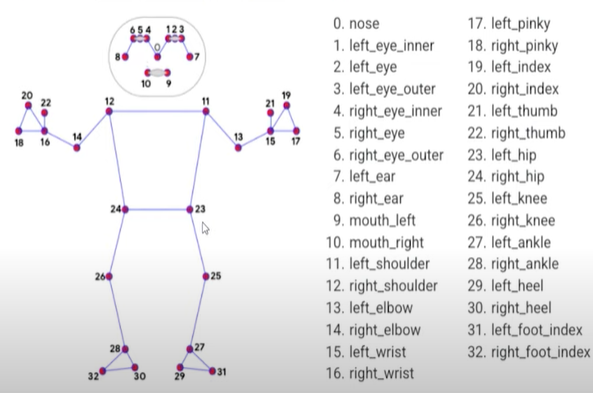

In [ ]:
!pip install mediapipe

In [ ]:
#Import libraries
import math
import cv2
import glob
import numpy as np
from time import time
import matplotlib.pyplot as plt
import mediapipe as mp #This is our main library that will work with pose detection
from google.colab.patches import cv2_imshow as cvimg #a required patch for working in colab

In [ ]:
#Attach to google drive so we can save our output there
from google.colab import drive
drive.mount('/content/drive/')
import os
import PIL.Image

os.getcwd()

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


'/content'

In [ ]:
with open('/content/drive/My Drive/foo.txt', 'w') as f:
  f.write('Hello Google Drive!')
!cat /content/drive/My\ Drive/foo.txt

Hello Google Drive!

In [ ]:
#Initialize the class mp.solutions.pose(), setup function is mp.solutions.pose.Pose(), arguments include:
#static_image_mode - boolean value that is set to false, treats the input images as a video stream
#Model_complexity - 0,1 or 2. Landmark accuracy as well as inference latency generally go up with the mode complexity, default is 1
#Smooth_Landmarks - default is true, solution filters pose landmarks across all input images to reduce jitter
#Enable_segmentation - default is false, if true in addition to the pose landmarks, the solution also generates the segmentation mask
#smooth_segmentation - If set to true, the solution filters segmentation masks across different input images to reduce jitter. Ignored if enable_segmentation 
#                      is false or static_image_mode is true. Default to true.
#Min_detection_confidence - Min required value [0.0 - 1.0] from the model for the detection to be considered successful, default is 0.5
#Min_tracking_confidence - Min value [0.0 - 1.0] from the model for the landmarks to be considered tracked successfully, higher is more robust but slower, default is 0.5

In [ ]:
#Lets start
#First lets just try it on a still image, we don't care about the latency since its a still image
mp_pose = mp.solutions.pose
pose = mp_pose.Pose(static_image_mode=True, min_detection_confidence=0.4, model_complexity=2)
pose_drawing = mp.solutions.drawing_utils
pose_drawing.DrawingSpec(color=(0,252,124), thickness=3, circle_radius=2)

DrawingSpec(color=(0, 252, 124), thickness=3, circle_radius=2)

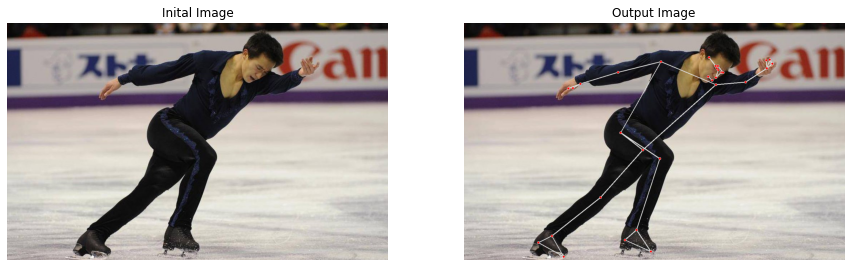

In [ ]:
#Reading the image
first_img = cv2.imread('Skating.png')
# Perform pose detection after converting the image into RGB format.
first_img_points = pose.process(cv2.cvtColor(first_img, cv2.COLOR_BGR2RGB))

#The above line returns a list of position points, not the image
#So we will copy the inital image, and draw them on it
first_img_skeleton = first_img.copy()
# Check if any landmarks are found
if first_img_points.pose_landmarks:
    
    # Draw Pose landmarks on the sample image
    pose_drawing.draw_landmarks(image=first_img_skeleton, landmark_list=first_img_points.pose_landmarks, connections=mp_pose.POSE_CONNECTIONS)

#Output results
fig = plt.figure(figsize=(15,15))
ax1 = fig.add_subplot(221)
ax1.set_title("Inital Image")
ax1.axis('off')
ax1.imshow(first_img[:,:,::-1])
ax2 = fig.add_subplot(222)
ax2.set_title("Output Image")
ax2.axis('off')
ax2.imshow(first_img_skeleton[:,:,::-1])
plt.show()

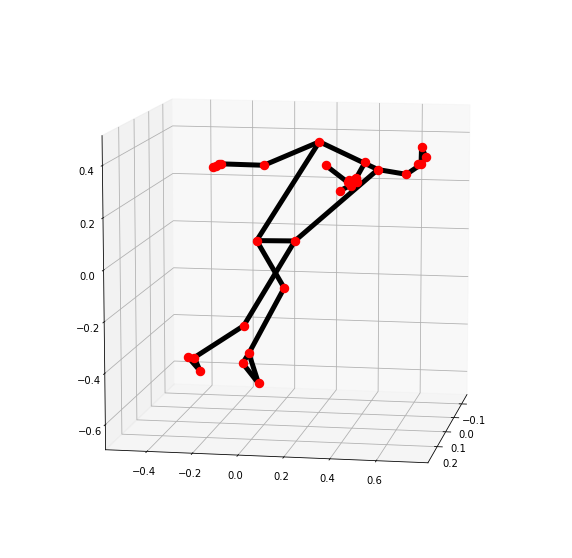

In [ ]:
#Lets visualize the plots in 3D
pose_drawing.plot_landmarks(first_img_points.pose_world_landmarks, mp_pose.POSE_CONNECTIONS)

In [ ]:
#Put this all together in a function
def poseDetecting(img, pose, display=True):
  '''
  This function uses mediapipe to preform pose detection on an image
  Args:
    Img:  (cv2 object)
    Pose: setup function (mediapipe object)
    display: (boolean)
  Returns:
    Output_img: input image with the points drawn
    landmarks: A list of the 33 locations on the person
  '''
  img_skel = img.copy() #Create an image copy so we can draw points on it later
  imgRGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) #Convert image to rgb from bgr
  points = pose.process(imgRGB) #preform the point collection
  height, width, _ = img.shape #get the image's height and width
  
  landmarks= [] #List to store detected landmarks

  if points.pose_landmarks: #Check if landmarks were detected
    pose_drawing.draw_landmarks(image=img_skel, landmark_list=points.pose_landmarks, connections=mp_pose.POSE_CONNECTIONS)

    for landmark in points.pose_landmarks.landmark:
      landmarks.append((int(landmark.x * width), int(landmark.y * height), (landmark.z * width)))

    if display: #Check if we must display them
        # Display the original input image and the resultant image.
        plt.figure(figsize=[22,22])
        plt.subplot(121)
        plt.imshow(img[:,:,::-1])
        plt.title("Original Image")
        plt.axis('off')
        plt.subplot(122)
        plt.imshow(img_skel[:,:,::-1])
        plt.title("Output Image")
        plt.axis('off')
        
        # Also Plot the Pose landmarks in 3D.
        pose_drawing.plot_landmarks(points.pose_world_landmarks, mp_pose.POSE_CONNECTIONS)
    
    #If display is off, we return the image and the landmarks
    else:
      return img_skel, landmarks


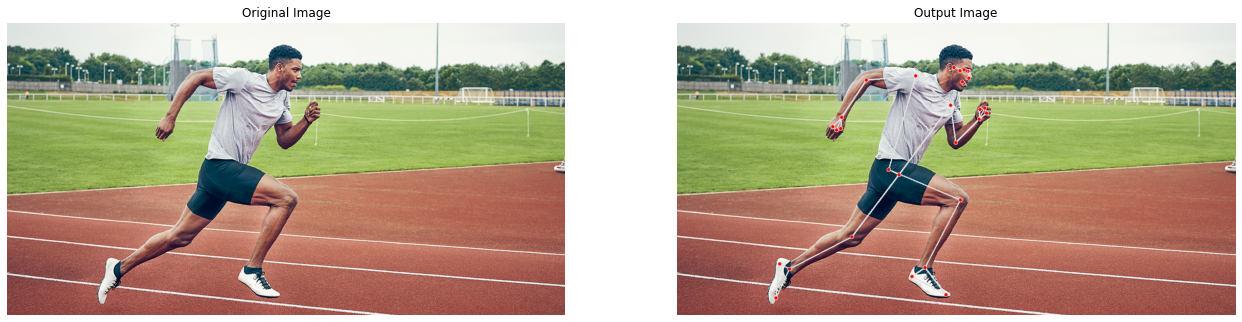

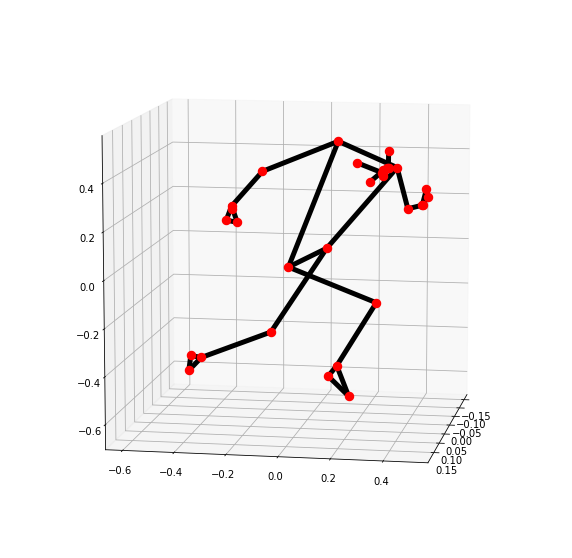

In [ ]:
#Lets call the above function and see if it works
second_img = cv2.imread('running.jpg')
poseDetecting(second_img, pose)

In [ ]:
#Lets now try to make this into a video
video_pose = mp_pose.Pose(static_image_mode=False, model_complexity=1, min_detection_confidence=0.5)

#Declaring all variables
video = cv2.VideoCapture('skating.mp4')
okay, frame = None, None

img_array = []
fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter('/content/drive/My Drive/projects/output2.avi', fourcc, 20.0, (640,480))
while video.isOpened():
  #Reads a frame
  okay, frame = video.read()
  if not okay:
    break
  frame = cv2.flip(frame, 1)#Flip the frame horizontally so we can view it properly
  frame_height, frame_width, _ = frame.shape
  try:
    frame, _ = poseDetecting(frame, video_pose, display=False)
  except:
    break
  # write the flipped frame
  img_array.append(frame)
  out.write(frame)
  
  #We want to implement a quit function, here we'll use the esc key
  key = cv2.waitKey(1)
  if key == 27:
    break

#End the video and close all windows
video.release()
out.release()
cv2.destroyAllWindows()
for i in range(len(img_array)):
  path = f"/content/drive/My Drive/projects/tmp/image{i}.png"
  PIL.Image.fromarray(cv2.cvtColor(img_array[i], cv2.COLOR_BGR2RGB), 'RGB').save(path)
print(len(img_array))


470


In [ ]:
! ffmpeg -r 30 -i /content/drive/My\ Drive/projects/tmp/image%d.png -vcodec mpeg4 -y /content/drive/My\ Drive/projects/movie.mp4

ffmpeg version 3.4.8-0ubuntu0.2 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)
  configuration: --prefix=/usr --extra-version=0ubuntu0.2 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lib